# 1. Overview

The notebook describes a modeling approach for forecasting ASML stock prices, exploring SARIMAX, Prophet, XGBoost, and Random Forest models. Data transformations ensured stationarity, with Prophet achieving the best results using exogenous variables. Models were evaluated based on RMSE and MAPE metrics, and after fine-tuning, Prophet showed significant performance improvement, thus selected as the primary model. The final model parameters were saved for future use, ensuring a robust forecasting framework incorporating market conditions and external factors.

# 2. Forecasting

## 2.1 Import Libraries

In [1]:
# pip install prophet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
import itertools
import joblib
import json
import pickle
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, ParameterGrid

# Desactivar logs de Prophet
logging.getLogger('cmdstanpy').disabled = True

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.2 Define Global variables

In [3]:
input_data = 'data/weekly_data_combination.csv'
output_model_path_train = 'models/prophet_asml_combination_with_suppliers_train.pkl'
output_best_params_path = 'data/best_prophet_params.json'
output_best_variables_path = 'data/best_prophet_variables_with_suppliers.json'
output_regressors_path = 'data/best_regressors.json'
output_start_data_and_test_weeks_path = 'data/start_data_and_test_weeks.pkl'

## 2.3 Functions

In [4]:
# Feature engineering for time series
def create_features(df):
    """
    Create time-based features for time series data.
    
    Input:
    - df: DataFrame with a datetime index and a single column for the target variable.

    Output:
    - df: DataFrame with added columns for year, month, week of the year, quarter, and cuatrimestre.

    Logic:
    - Extracts the 'year', 'month', 'week_of_year', 'quarter', and 'cuatrimestre' 
      from the datetime index to create additional time-based features.
    """
    df = df.copy()  # Create a copy of the DataFrame to avoid the warning
    df['year'] = df.index.year            # Extract year from the date
    df['month'] = df.index.month          # Extract month from the date
    df['week_of_year'] = df.index.isocalendar().week  # Extract week of the year from the date
    df['quarter'] = df.index.quarter      # Extract quarter from the date
    df['cuatrimestre'] = ((df.index.month - 1) // 4) + 1  # Calculate cuatrimestre (four-month period)
    return df

## 2.4 Code

Loading the data from notebook 04_data_preparation

In [5]:
weekly_data_combination = pd.read_csv(input_data, sep=';')

# Ensure the 'Date' column is in datetime format
weekly_data_combination['Date'] = pd.to_datetime(weekly_data_combination['Date'])

# Set the 'Date' column as the index to make it a DatetimeIndex
weekly_data_combination.set_index('Date', inplace=True)

# Explicitly set the frequency of the Date index
weekly_data_combination = weekly_data_combination.asfreq('W')


weekly_data_combination.head()

,Close_ASML,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,
2018-01-14,168.662354,60.946632,10.902242,32.766666,0,0,0,0,0,0
2018-01-21,185.736542,60.851768,11.676138,34.386667,0,0,0,0,0,0
2018-01-28,191.564713,61.373486,11.899403,34.026669,0,0,0,0,0,0
2018-02-04,187.825378,61.335552,10.869248,31.420000,0,0,0,0,0,0
2018-02-11,174.080200,58.831280,9.690061,28.526667,0,0,0,0,0,0


Read the start_data and test_weeks from notebook 01_data_understanding

In [6]:
# Load the variables using pickle
with open(output_start_data_and_test_weeks_path, 'rb') as f:
    variables = pickle.load(f)

# Extract the variables
start_date = variables['start_date']
test_weeks = variables['test_weeks']

### 2.4.1 Train test split

We are going to consider *test_weeks* as the number of weeks we want the test to have

In [7]:
train_data = weekly_data_combination[:-test_weeks]
train_data.head()

,Close_ASML,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,
2018-01-14,168.662354,60.946632,10.902242,32.766666,0,0,0,0,0,0
2018-01-21,185.736542,60.851768,11.676138,34.386667,0,0,0,0,0,0
2018-01-28,191.564713,61.373486,11.899403,34.026669,0,0,0,0,0,0
2018-02-04,187.825378,61.335552,10.869248,31.420000,0,0,0,0,0,0
2018-02-11,174.080200,58.831280,9.690061,28.526667,0,0,0,0,0,0


In [8]:
test_data = weekly_data_combination[-test_weeks:]
test_data.head()

,Close_ASML,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,
2024-09-08,809.584839,66.605000,75.787483,79.215000,0,1,1,1,1,1
2024-09-15,798.271362,63.835999,74.551239,82.000000,0,1,1,1,1,1
2024-09-22,801.164551,65.324997,76.603996,83.349998,0,1,1,1,1,1
2024-09-29,816.269165,70.800003,80.375000,85.470001,0,1,1,1,1,1
2024-10-06,830.465942,74.760002,81.408997,88.830002,0,1,1,1,1,1


Let's visualize what would be the result of the train and test dataframes

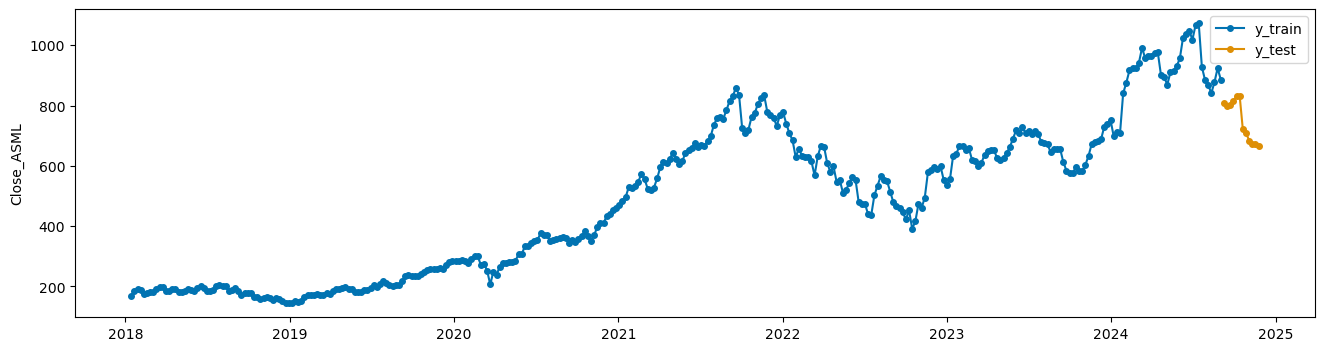

In [9]:
plot_series(train_data['Close_ASML'], test_data['Close_ASML'], labels=["y_train", "y_test"]);

### 2.4.2 SARIMAX

As we saw in notebook 02_forecasting, the series was not stationary, thus we will make the target variable stationary (which is 'Close_ASML') following the same logic that was done in notebook 02_forecasting

Step 1: Log transformation (to stabilize variance)

In [10]:
log_train_data = np.log(train_data['Close_ASML'])

Step 2: Check stationarity using the Augmented Dickey-Fuller test and Differencing if necessary

In [11]:
# Augmented Dickey-Fuller test
result = adfuller(log_train_data, autolag='AIC')
p_value = result[1]
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {p_value}')

if p_value > 0.05:
    print("The series is not stationary. Applying differencing.")
    # Differencing to achieve stationarity
    diff_log_train_data = log_train_data.diff().dropna()

    # Check stationarity again after differencing
    result_diff = adfuller(diff_log_train_data, autolag='AIC')
    p_value_diff = result_diff[1]
    print(f'ADF Statistic after differencing: {result_diff[0]}')
    print(f'p-value after differencing: {p_value_diff}')

    if p_value_diff > 0.05:
        print("The series is still not stationary.")
    else:
        print("The series is now stationary with differencing.")
    train_data_stationary = diff_log_train_data
else:
    print("The series is stationary with only log.")
    train_data_stationary = log_train_data

ADF Statistic: -0.8383403637901538
p-value: 0.8075997072861467
The series is not stationary. Applying differencing.
ADF Statistic after differencing: -17.00147704320276
p-value after differencing: 8.722321551107368e-30
The series is now stationary with differencing.


Plot the transformed data to visualize

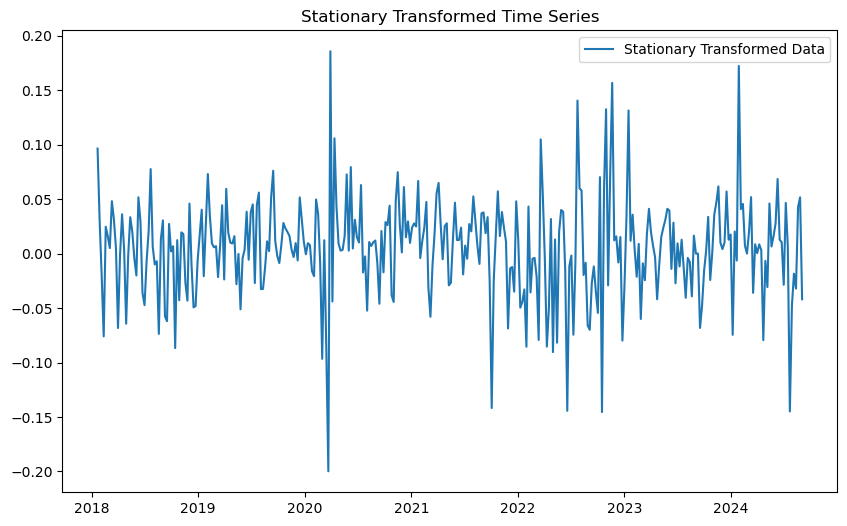

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(train_data_stationary, label='Stationary Transformed Data')
plt.title('Stationary Transformed Time Series')
plt.legend()
plt.show()

Once we have the stationary series, we initialize the SARIMAX model with the corresponding regressor variables

In [13]:
# Creating the exogenous variables
exog = train_data.drop(['Close_ASML'], axis=1)
# Deleting the first row of exog due to the differentiation
exog = exog[1:]

# Initializing the SARIMAX model
sarima_model = SARIMAX(
    train_data_stationary,     # Training data that is stationary
    exog=exog,                 # Exogenous variables
    order=(1, 1, 1),           # ARIMA order (p, d, q)
    seasonal_order=(1, 1, 1, 52),  # Seasonal order (P, D, Q, s), here s=52 for weekly data
    enforce_stationarity=False,  # Allow the model to be non-stationary
    enforce_invertibility=False  # Allow the model to be non-invertible
)

In [14]:
# Fit the model to the training data
fitted_sarima = sarima_model.fit(disp=False)

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
# Generate predictions the future_exog variable
future_exog = test_data.drop('Close_ASML', axis=1)

# Assuming `future_exog` contains the future values of the exogenous variables for the forecast period
y_pred_sarima = fitted_sarima.forecast(steps=len(test_data), exog=future_exog)

Now we have to revert the transformations

In [16]:
# Step 1: Revert the differencing
# 'last_original_value' is the last value before differencing was applied
last_original_value = log_train_data.iloc[-1]

# Add back the last original value to get the cumulative sum and revert differencing
y_pred_sarima_diff_reverted = np.r_[last_original_value, y_pred_sarima].cumsum()

# Remove the first value to match the length of test_data
y_pred_sarima_diff_reverted = y_pred_sarima_diff_reverted[1:]

# Step 2: Revert the logarithmic transformation
y_pred_sarima_reverted = np.exp(y_pred_sarima_diff_reverted)

# Convert the reverted predictions to a pandas Series
y_pred_sarima_reverted = pd.Series(y_pred_sarima_reverted, index=test_data.index)

Let's plot the data and predictions

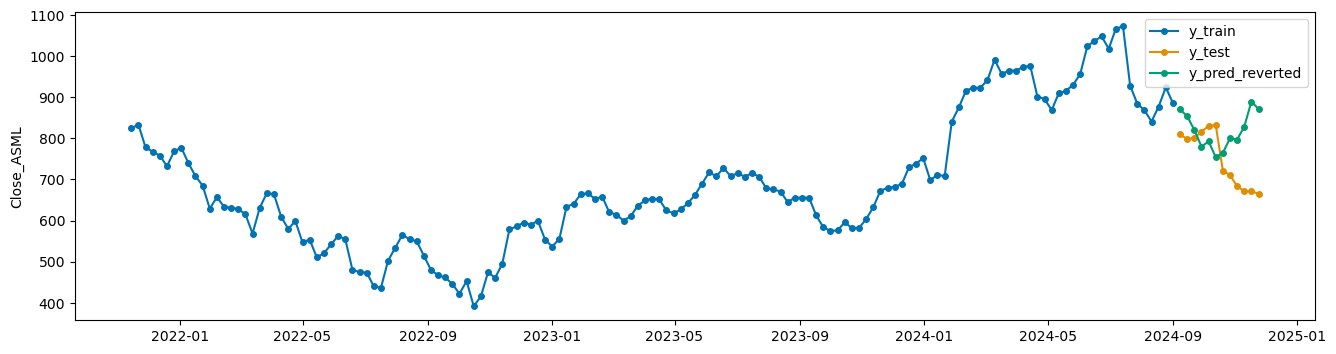

In [17]:
# Plot the training, test data, and predictions
plot_series(train_data['Close_ASML'][200:], test_data['Close_ASML'], y_pred_sarima_reverted, labels=["y_train", "y_test", "y_pred_reverted"]);

In [18]:
# Calculate MAPE for SARIMA model
mape_sarima = mean_absolute_percentage_error(test_data['Close_ASML'], y_pred_sarima_reverted) * 100
mape_sarima

13.12940246520015

In [19]:
# Calculate RMSE for SARIMA model
rmse_sarima = root_mean_squared_error(test_data['Close_ASML'], y_pred_sarima_reverted)
rmse_sarima

113.22854542207564

The results are not good if they're compared with those of notebook 02_forecasting. So, we are disregarding the SARIMAX model for now.

### 2.4.3 Prophet

Initialize the Prophet model

In [20]:
prophet_model = Prophet()

Fit the model to the data

First we need to modify the column names as is required by prophet

In [21]:
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})
train_data_prophet.head()

,ds,y,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
0,2018-01-14,168.662354,60.946632,10.902242,32.766666,0,0,0,0,0,0
1,2018-01-21,185.736542,60.851768,11.676138,34.386667,0,0,0,0,0,0
2,2018-01-28,191.564713,61.373486,11.899403,34.026669,0,0,0,0,0,0
3,2018-02-04,187.825378,61.335552,10.869248,31.420000,0,0,0,0,0,0
4,2018-02-11,174.080200,58.831280,9.690061,28.526667,0,0,0,0,0,0


In [22]:
test_data_prophet = test_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})
test_data_prophet.head()

,ds,y,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
0,2024-09-08,809.584839,66.605000,75.787483,79.215000,0,1,1,1,1,1
1,2024-09-15,798.271362,63.835999,74.551239,82.000000,0,1,1,1,1,1
2,2024-09-22,801.164551,65.324997,76.603996,83.349998,0,1,1,1,1,1
3,2024-09-29,816.269165,70.800003,80.375000,85.470001,0,1,1,1,1,1
4,2024-10-06,830.465942,74.760002,81.408997,88.830002,0,1,1,1,1,1


Add each regressor to the Prophet model

In [23]:
# Define the regressors list
regressors = list(test_data_prophet.columns)

# Exclude 'y' and 'ds' from the regressors list
regressors = [col for col in regressors if col not in ['y', 'ds']]

for regressor in regressors:
    prophet_model.add_regressor(regressor)

Fit the model

In [24]:
prophet_model.fit(train_data_prophet)

In [25]:
# Generate predictions
forecast = prophet_model.predict(test_data_prophet[[column for column in test_data_prophet if column != 'y']])
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,COVID_Period,COVID_Period_lower,COVID_Period_upper,Close_Carl_Zeiss_Meditec,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-09-08,786.071960,753.252654,829.256821,786.071960,786.071960,0.0,0.0,0.0,-88.892751,...,2.526542,2.526542,2.526542,1.119719,1.119719,1.119719,0.0,0.0,0.0,789.718220
1,2024-09-15,788.168845,739.719227,817.781177,788.168845,788.168845,0.0,0.0,0.0,-93.855763,...,-2.562886,-2.562886,-2.562886,-5.650029,-5.650029,-5.650029,0.0,0.0,0.0,779.955930
2,2024-09-22,790.265730,754.021295,827.714153,790.252666,790.265730,0.0,0.0,0.0,-91.186961,...,10.524209,10.524209,10.524209,-10.812237,-10.812237,-10.812237,0.0,0.0,0.0,789.977702
3,2024-09-29,792.362615,783.094754,855.033938,792.302403,792.399081,0.0,0.0,0.0,-81.373846,...,38.861047,38.861047,38.861047,-11.682549,-11.682549,-11.682549,0.0,0.0,0.0,819.541113
4,2024-10-06,794.459500,804.867985,880.084975,794.362301,794.552068,0.0,0.0,0.0,-74.276151,...,55.785796,55.785796,55.785796,-8.896001,-8.896001,-8.896001,0.0,0.0,0.0,841.349295


Plot forecast components (trend, weekly, yearly components)

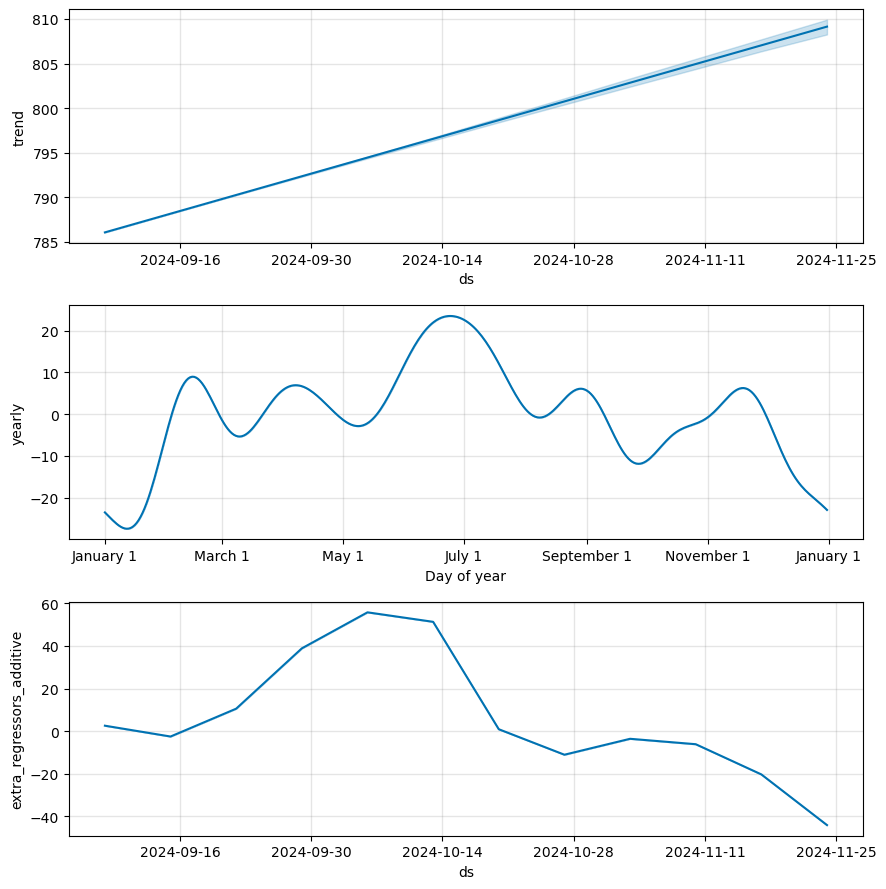

In [26]:
fig2 = prophet_model.plot_components(forecast)
plt.show()

The Prophet model's forecast shows a steady upward trend, indicating growth over time. There is clear yearly seasonality, with peaks around July and dips towards the year's end, suggesting cyclical behavior. An additional regressor also impacts the forecast, introducing periodic fluctuations that align with external factors. Together, these components suggest the forecast is influenced by an overall upward trend, annual cycles, and external variables.

In [27]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

forecast

,Close
ds,
2024-09-08,789.718220
2024-09-15,779.955930
2024-09-22,789.977702
2024-09-29,819.541113
2024-10-06,841.349295
2024-10-13,842.515627
2024-10-20,796.282814
2024-10-27,787.615183
2024-11-03,799.366617


In [28]:
# Ensure ds is the index of train_data_prophet 
train_data_prophet = train_data_prophet.set_index('ds')

# Ensure ds is the index of test_data_prophet 
test_data_prophet = test_data_prophet.set_index('ds')

Plot the forecast results

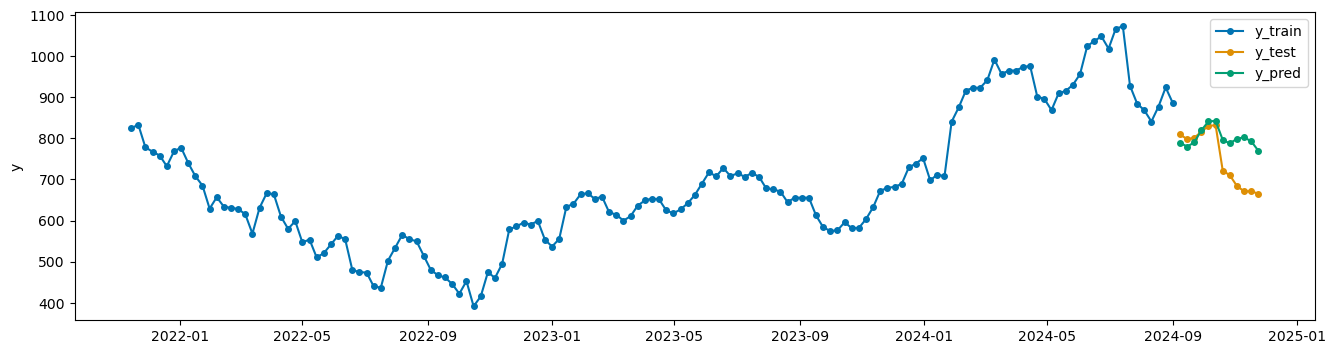

In [29]:
plot_series(train_data_prophet[['y']][200:], test_data_prophet[['y']], forecast, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [30]:
mape_prophet = mean_absolute_percentage_error(test_data_prophet['y'], forecast) * 100
mape_prophet

8.387080753909043

In [31]:
rmse_prophet = root_mean_squared_error(test_data_prophet['y'], forecast)
rmse_prophet

75.79493116004639

The results are very positive. So, it's interesting to consider the extra information that the regressors provide. We will still try other models to see their results. All things considered, results seem to be good for now.

### 2.4.6 XGboost

We will try again XGBoost as we did in notebook 02_forecasting and we will do so using the temporal variables using the create_features function.

In [32]:
train_data_xgb_rf = create_features(train_data)
test_data_xgb_rf = create_features(test_data)

In [33]:
# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_xgb = train_data_xgb_rf.drop('Close_ASML', axis=1)
y_train_xgb = train_data_xgb_rf['Close_ASML']
X_test_xgb = test_data_xgb_rf.drop('Close_ASML', axis=1)
y_test_xgb = test_data_xgb_rf['Close_ASML']

In [34]:
# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,       # Number of trees
    learning_rate=0.1,      # Step size shrinkage
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

In [35]:
# Train the model
xgb_model.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [36]:
# Generate predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_xgb = pd.DataFrame(y_pred_xgb, index=test_data.index, columns=['Close_ASML'])

In [37]:
# Evaluate the model's performance
rmse_xgb = root_mean_squared_error(y_test_xgb, y_pred_xgb)
rmse_xgb

94.13546189124251

In [38]:
mape_xgb = mean_absolute_percentage_error(y_test_xgb, y_pred_xgb)*100
mape_xgb

9.663441571353236

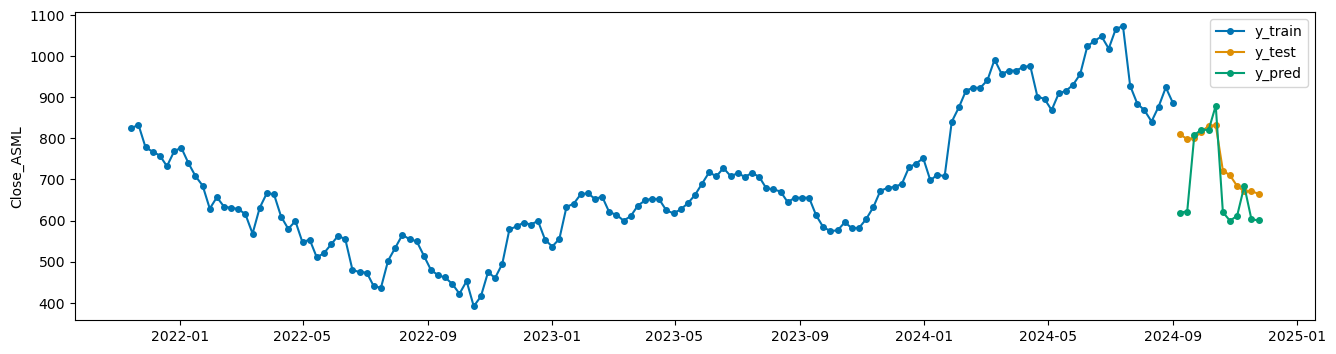

In [39]:
# Plot actual vs. predicted values
plot_series(y_train_xgb[200:], y_test_xgb, y_pred_xgb, labels=["y_train", "y_test", "y_pred"]);

Results if compared with the previous prophet models are not so good in a numerical and visual sense and so, we will still choose the prophet as our main model.

### 2.4.7 Random Forest

We will proceed with the Random Forest model using the same logic that we used for XGBoost.

In [40]:
# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_rf = train_data_xgb_rf.drop('Close_ASML', axis=1)
y_train_rf = train_data_xgb_rf['Close_ASML']
X_test_rf = test_data_xgb_rf.drop('Close_ASML', axis=1)
y_test_rf = test_data_xgb_rf['Close_ASML']

In [41]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,       # Number of trees
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

In [42]:
# Train the model
rf_model.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=5, random_state=42)

In [43]:
# Generate predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Convert predictions to a DataFrame with the same index as the test data
y_pred_rf = pd.DataFrame(y_pred_rf, index=test_data.index, columns=['Close'])

In [44]:
# Evaluate the model's performance
rmse_rf = root_mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf

85.47533981245648

In [45]:
mape_rf = mean_absolute_percentage_error(y_test_rf, y_pred_rf)*100
mape_rf

9.469421844783703

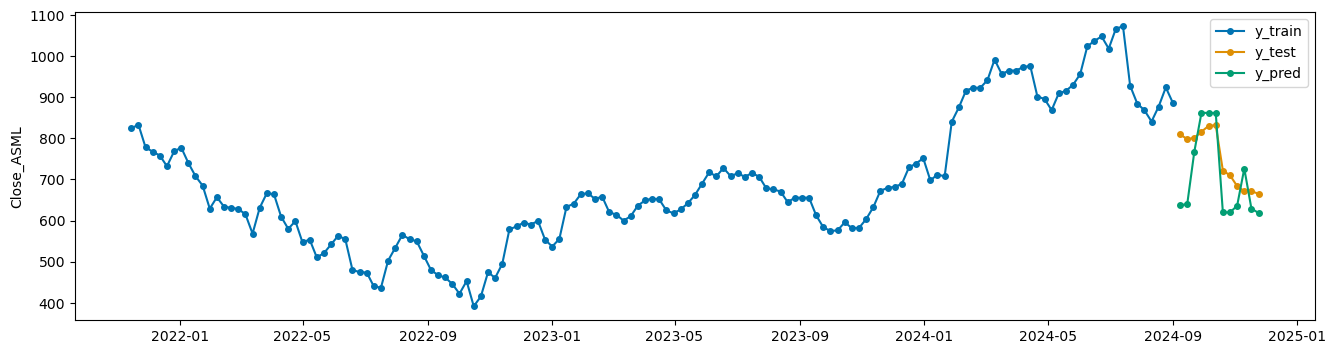

In [46]:
# Plot actual vs. predicted values
plot_series(y_train_rf[200:], y_test_rf, y_pred_rf, labels=["y_train", "y_test", "y_pred"]);

The results are far from convincing. So, we decide to keep with the prophet model. Nevertheless, we will create a table that compares the MAPE and RMSE results of all the models in the following code cells.

### 2.4.8 RMSE and MAPE comparison

In [47]:
# Create a dictionary to store RMSE and MAPE for each model
metrics = {
    "Model": ["SARIMAX", "Prophet", "XGBoost", "Random Forest"],
    "RMSE": [
        rmse_sarima,
        rmse_prophet,
        rmse_xgb,
        rmse_rf
    ],
    "MAPE": [
        mape_sarima,
        mape_prophet,
        mape_xgb,
        mape_rf
    ]
}

In [48]:
# Convert the dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics)

metrics_df

,Model,RMSE,MAPE
0,SARIMAX,113.228545,13.129402
1,Prophet,75.794931,8.387081
2,XGBoost,94.135462,9.663442
3,Random Forest,85.475340,9.469422


Our best model is Prophet as it has the lowest RMSE and MAPE. We shall now proceed to do a fine-tunning of the prophet model. We will be disregarding the other models because they are significantly worse in performance.

### 2.4.9 Checking for the best regressors

Let's define the new parameters in the regressor dictionary that interests us

In [49]:
# Extracting the coefficients of the regressors from a trained Prophet model
# Ensure the prophet_model has been trained with regressors

# The model's trained parameters are stored in prophet_model.params
model_params = prophet_model.params

# Access the dataframe containing the coefficients for extra regressors
# 'beta' contains the coefficients for additional regressors
regressor_coefficients = model_params['beta'][0]

# Extract the names of the regressors
# These are stored in the model's 'extra_regressors' attribute
regressor_names = list(prophet_model.extra_regressors.keys())

# Combine the regressor names with their corresponding coefficients
# This creates a dictionary where the keys are regressor names and values are coefficients
regressor_coefficients_dict = dict(zip(regressor_names, regressor_coefficients))

# Find the top 5 regressors with the highest coefficients (absolute values)
# Sort the dictionary by absolute values of the coefficients in descending order
new_regressors = sorted(regressor_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:5]

# Convert the top 5 regressors into a list of tuples
new_regressors_list = [regressor for regressor, coefficient in new_regressors]

# Print the top 5 regressors with the highest coefficients
print("\nTop 5 Regressors with Highest Coefficients:")
for regressor in new_regressors_list:
    print(f"{regressor}")


Top 5 Regressors with Highest Coefficients:
Close_Lam_Research_Corporation
Trade_Sanctions
New_Product_Launch
Israel_Gaza_Conflict
Tech_Regulation


Let's keep these top 5 regressors in the train_data_prophet and test_data_prophet

In [50]:
train_data_prophet = train_data_prophet[['y'] + new_regressors_list]
train_data_prophet = train_data_prophet.reset_index(names="ds")

train_data_prophet

,ds,y,Close_Lam_Research_Corporation,Trade_Sanctions,New_Product_Launch,Israel_Gaza_Conflict,Tech_Regulation
0,2018-01-14,168.662354,10.902242,0,0,0,0
1,2018-01-21,185.736542,11.676138,0,0,0,0
2,2018-01-28,191.564713,11.899403,0,0,0,0
3,2018-02-04,187.825378,10.869248,0,0,0,0
4,2018-02-11,174.080200,9.690061,0,0,0,0
...,...,...,...,...,...,...,...
342,2024-08-04,868.516907,85.226768,1,1,1,1
343,2024-08-11,841.041199,76.805382,1,1,1,1
344,2024-08-18,877.525818,84.276657,1,1,1,1
345,2024-08-25,924.016968,86.024345,1,1,1,1


In [51]:
test_data_prophet = test_data_prophet[['y'] + new_regressors_list]
test_data_prophet = test_data_prophet.reset_index(names="ds")

test_data_prophet

,ds,y,Close_Lam_Research_Corporation,Trade_Sanctions,New_Product_Launch,Israel_Gaza_Conflict,Tech_Regulation
0,2024-09-08,809.584839,75.787483,1,1,1,1
1,2024-09-15,798.271362,74.551239,1,1,1,1
2,2024-09-22,801.164551,76.603996,1,1,1,1
3,2024-09-29,816.269165,80.375000,1,1,1,1
4,2024-10-06,830.465942,81.408997,1,1,1,1
5,2024-10-13,832.022278,82.059998,1,1,1,1
6,2024-10-20,721.570862,74.139999,1,1,1,1
7,2024-10-27,710.037903,73.000000,1,1,1,1
8,2024-11-03,683.830017,75.449997,1,1,1,1
9,2024-11-10,671.159973,76.779999,1,1,1,1


### 2.4.10 Fine-tunning

We will first run a code using a param_grid to gain an understanding of the approximate locations of the global minimal for ASML. 
(Expected execution time 10 minutes)

Best parameters for ASML: {'changepoint_prior_scale': 0.301, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.01, 'weekly_seasonality': True, 'yearly_seasonality': True}
MAPE: 5.05
RMSE: 43.06


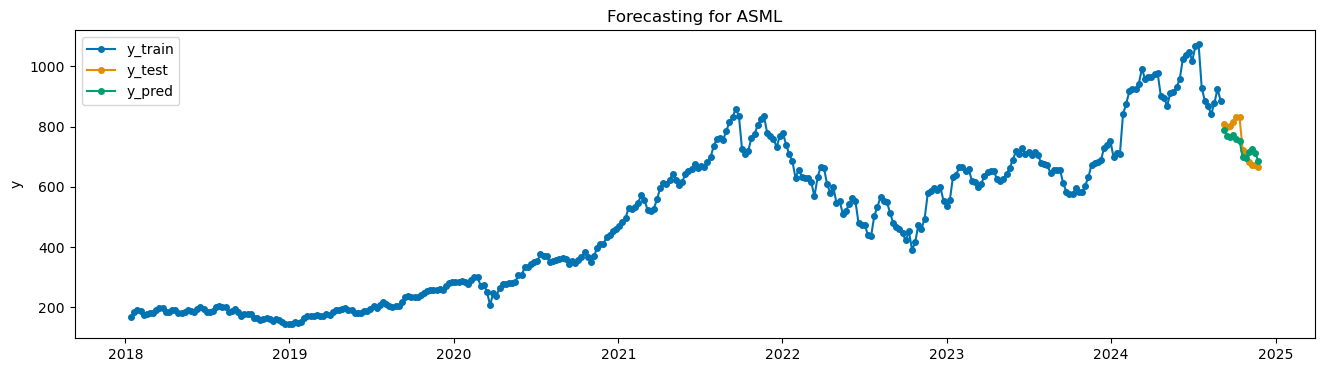

In [52]:
# Dictionary to store the best parameters and performance metrics
best_params_per_company = {}
final_mape_per_company = {}
final_rmse_per_company = {}
company_params = {}

# Define parameter grid
param_grid = {
    "changepoint_prior_scale": [round(x, 3) for x in np.arange(0.001, 1.001, 0.1)],
    "seasonality_prior_scale": [round(x, 2) for x in np.arange(0.01, 10.1, 1)],
    "seasonality_mode": ['multiplicative'],
    "weekly_seasonality": [True, False],
    "yearly_seasonality": [True, False],
    "daily_seasonality": [True, False]
}

# Create a parameter grid generator
grid = ParameterGrid(param_grid)

# Initialize variables to track the best parameters
best_mape = float('inf')
best_rmse = float('inf')
best_params = None
best_forecast = None

# Perform grid search
for params in grid:
    try:
        # Initialize the Prophet model with parameters from the grid
        prophet_model = Prophet(
            changepoint_prior_scale=params["changepoint_prior_scale"],
            seasonality_prior_scale=params["seasonality_prior_scale"],
            seasonality_mode=params["seasonality_mode"],
            weekly_seasonality=params["weekly_seasonality"],
            yearly_seasonality=params["yearly_seasonality"],
            daily_seasonality=params["daily_seasonality"]
        )

        # Add new regressors
        for regressor in new_regressors_list:
            prophet_model.add_regressor(regressor)
        
        # Fit the model
        prophet_model.fit(train_data_prophet)
        
        # Generate predictions
        future = test_data_prophet.reset_index()[[column for column in test_data_prophet.reset_index() if column != 'y']]
        forecast = prophet_model.predict(future)
        forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

        # Calculate MAPE and RMSE
        actuals = test_data_prophet['y']
        actuals.index = test_data_prophet['ds']
        predictions = forecast['Close']
        common_index = actuals.index.intersection(predictions.index)
        mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100
        rmse = root_mean_squared_error(actuals.loc[common_index], predictions.loc[common_index])

        # Update the best parameters if the current MAPE is lower
        if mape < best_mape:
            best_mape = mape
            best_rmse = rmse
            best_params = params
            best_forecast = forecast

    except Exception as e:
        print(f"Error with parameters: {params}: {e}")

# Store the best parameters and performance metrics for ASML
best_params_per_company["ASML"] = best_params
final_mape_per_company["ASML"] = best_mape
final_rmse_per_company["ASML"] = best_rmse
company_params["ASML"] = best_params

# Print the best parameters, MAPE, and RMSE
print(f"Best parameters for ASML: {best_params}")
print(f"MAPE: {best_mape:.2f}")
print(f"RMSE: {best_rmse:.2f}")

# Ensure 'ds' is the index for train and test datasets
train_data_prophet_plot = train_data_prophet.set_index('ds')
test_data_prophet_plot = test_data_prophet.set_index('ds')

# Plot the forecast results for ASML
plot_series(
    train_data_prophet_plot['y'][-500:],  # Last 500 points of training data
    test_data_prophet_plot['y'],
    best_forecast['Close'],
    labels=["y_train", "y_test", "y_pred"]
)

plt.title("Forecasting for ASML")
plt.show()

Now let's run a specific param_grid for ASML
(Expected execution time 10-15 minutes)


Best parameters for ASML: {'changepoint_prior_scale': 0.50167, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 11.67833, 'weekly_seasonality': True, 'yearly_seasonality': True}
MAPE: 5.02
RMSE: 44.15


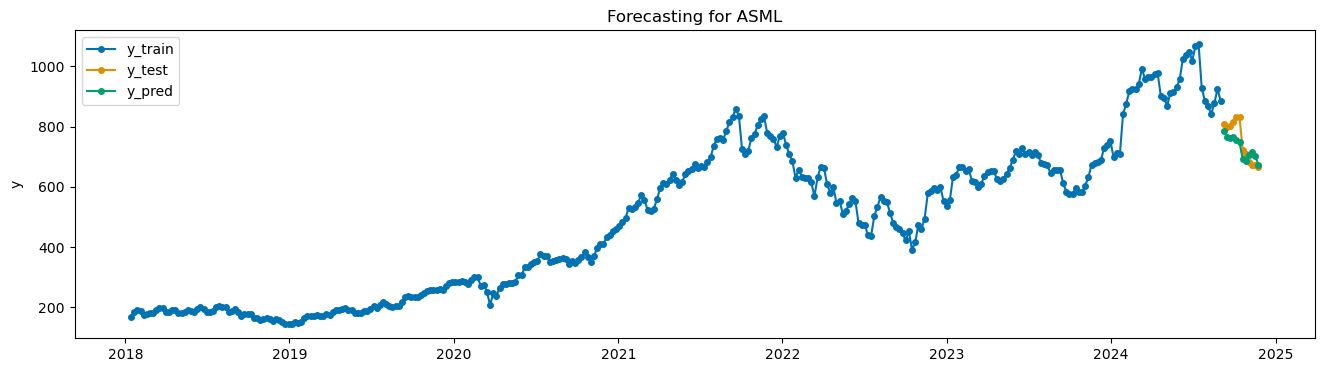

In [53]:
# Define ASML-specific parameters from company_params
params = company_params["ASML"]

# Define the parameter grid for ASML
param_grid = {
    'changepoint_prior_scale': np.round(
        np.linspace(params['changepoint_prior_scale'] / 2, params['changepoint_prior_scale'] * 2, 10), 5
    ),
    'seasonality_prior_scale': np.round(
        np.linspace(params['seasonality_prior_scale'] / 2, params['seasonality_prior_scale'] * 2, 10), 5
    ),
    'seasonality_mode': ['multiplicative'],
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False],
    'daily_seasonality': [True, False]
}

# Generate all parameter combinations using ParameterGrid
param_combinations = list(ParameterGrid(param_grid))

# Initialize variables to track the best parameters
best_mape = float('inf')
best_rmse = float('inf')
best_params = None
best_mape_train = float('inf')
best_rmse_train = float('inf')
best_forecast_train = None

# Iterate over all parameter combinations
for combination in param_combinations:
    try:
        
        # Fit the Prophet model with the current parameter combination
        model = Prophet(
            changepoint_prior_scale=combination['changepoint_prior_scale'],
            seasonality_prior_scale=combination['seasonality_prior_scale'],
            seasonality_mode=combination['seasonality_mode'],
            weekly_seasonality=combination['weekly_seasonality'],
            yearly_seasonality=combination['yearly_seasonality'],
            daily_seasonality=combination['daily_seasonality']
        )
        # Add new regressors        
        for regressor in new_regressors_list:
            model.add_regressor(regressor)
        
        train_data_prophet.reset_index(drop=True, inplace=True)
            
        # Fit the model
        model.fit(train_data_prophet)

        # Make predictions
        future = test_data_prophet.reset_index()[[column for column in test_data_prophet.reset_index() if column != 'y']]
        forecast = model.predict(future)
        forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]
        
        # Make predictions train
        future_train = train_data_prophet.reset_index()[[column for column in train_data_prophet.reset_index() if column != 'y']]
        forecast_train = model.predict(future_train)
        forecast_train = forecast_train[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})

        # Calculate MAPE and RMSE
        actuals = test_data_prophet['y']
        actuals.index = test_data_prophet['ds']
        predictions = forecast['Close']
        
        common_index = actuals.index.intersection(predictions.index)
        mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100
        rmse = root_mean_squared_error(actuals.loc[common_index], predictions.loc[common_index])
                
        # Calculate MAPE and RMSE train
        actuals_train = train_data_prophet['y']
        actuals_train.index = train_data_prophet['ds']
        predictions_train = forecast_train['Close']
        
        # For train
        common_index_train = actuals_train.index.intersection(predictions_train.index)
        mape_train = mean_absolute_percentage_error(actuals_train.loc[common_index_train], predictions_train.loc[common_index_train]) * 100
        rmse_train = root_mean_squared_error(actuals_train.loc[common_index_train], predictions_train.loc[common_index_train])
        
        # Update the best parameters if the current MAPE is lower
        if mape < best_mape:
            best_mape = mape
            best_rmse = rmse
            best_params = combination            
            best_forecast = forecast
            best_mape_train = mape_train
            best_rmse_train = rmse_train
            best_forecast_train = forecast_train
                        

    except Exception as e:
        print(f"Error with parameters: {combination}")


# Print the best parameters, MAPE, and RMSE for ASML
print(f"\nBest parameters for ASML: {best_params}")
print(f"MAPE: {best_mape:.2f}")
print(f"RMSE: {best_rmse:.2f}")

# Plot the forecast results for ASML
model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    weekly_seasonality=best_params['weekly_seasonality'],
    yearly_seasonality=best_params['yearly_seasonality'],
    daily_seasonality=best_params['daily_seasonality']
)

train_data_prophet.reset_index(drop=True, inplace=True)
model.fit(train_data_prophet)

future = model.make_future_dataframe(periods=test_weeks, freq='W')
forecast = model.predict(future)
forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

# Ensure 'ds' is the index for train and test datasets
train_data_prophet_plot = train_data_prophet.set_index('ds')
test_data_prophet_plot = test_data_prophet.set_index('ds')

plot_series(
    train_data_prophet_plot['y'][-500:],  # Last 500 points of training data
    test_data_prophet_plot['y'],
    best_forecast['Close'],
    labels=["y_train", "y_test", "y_pred"]
)
plt.title("Forecasting for ASML")
plt.show()

Plot the forecast results

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [54]:
mape_prophet_best = mean_absolute_percentage_error(test_data_prophet['y'], best_forecast) * 100

mape_prophet_best

5.015904733113205

In [55]:
rmse_prophet_best = root_mean_squared_error(test_data_prophet['y'], best_forecast)
rmse_prophet_best

44.146941253717316

As can be seen, the prophet RMSE and MAPE results improve with the fine-tunning

### 2.4.11 Checking for Overfitting

In [56]:
mape_prophet_best_train = mean_absolute_percentage_error(train_data_prophet['y'], best_forecast_train) * 100
mape_prophet_best_train

3.0903882199704706

In [57]:
rmse_prophet_best_train = root_mean_squared_error(train_data_prophet['y'], best_forecast_train)
rmse_prophet_best_train

18.09542839440715

There is overfitting as is visible because we are working with a time series model and it's normal. Nevertheless, it is not a very big overfitting.

### 2.4.11 Results

The final fine-tune prophet model improved the MAPE and the RMSE results with respect to the non-fine tunned prophet model

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

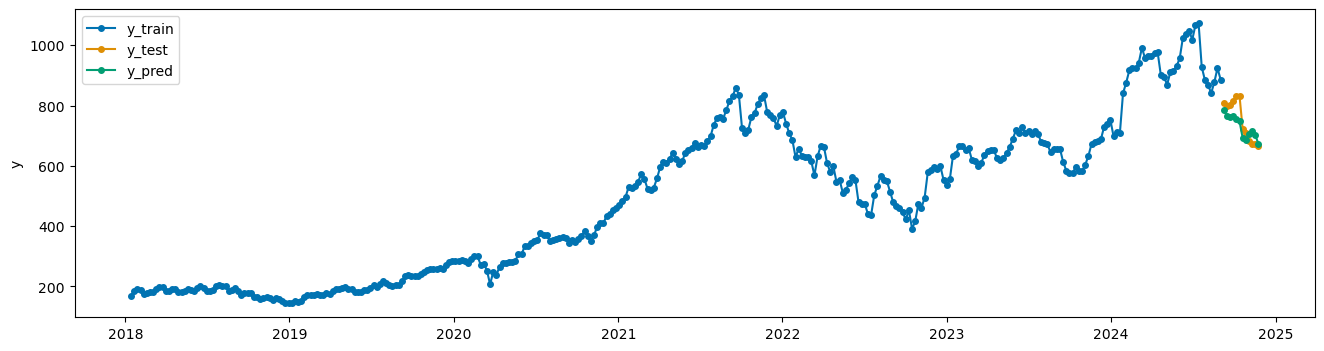

In [58]:
plot_series(
    train_data_prophet_plot['y'][-500:],  # Last 500 points of training data
    test_data_prophet_plot['y'],
    best_forecast['Close'],
    labels=["y_train", "y_test", "y_pred"]
)

### 2.5 Save the best model, best rmse and MAPE, and the top regressors

Saving the rmse_prophet_best and rmse_prophet_best variables

In [59]:
# Variable definition
best_prophet_variables_with_suppliers = {"rmse_prophet_best_with_suppliers": rmse_prophet_best, 
                                         "mape_prophet_best_with_suppliers": mape_prophet_best}

# Save the variable to a JSON file
with open(output_best_variables_path, 'w') as file:
    json.dump(best_prophet_variables_with_suppliers, file)

Saving the top five regressors

In [60]:
new_regressors = {'chosen_regressors':new_regressors_list}

# Save the variable to a JSON file
with open(output_regressors_path, 'w') as file:
    json.dump(new_regressors, file)

Saving the best model

In [61]:
# Save the best parameters to a JSON file
with open(output_best_params_path, 'w') as file:
    json.dump(best_params, file, indent=4)

Saving the best model with train_data

In [62]:
# Saving the best model with train_data
joblib.dump(model, output_model_path_train)

['models/prophet_asml_combination_with_suppliers_train.pkl']